In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.utils.common import function
from tf_agents.policies.policy_saver import PolicySaver

In [3]:
env_name = "MountainCar-v0"

#Network params
fc_layer_params = (64, 64)

#Agent params
learning_rate = 1e-3
target_update_period = 4000
discount_factor = 1
global_step = tf.Variable(0) #tf.compat.v1.train.get_or_create_global_step()

#Replay buffer
replay_buffer_capacity = 10000

#Dataset
batch_size = 64

#Training
num_training_steps = 250000

# Make the environment

In [4]:
train_env_py = suite_gym.load(env_name)
eval_env_py = suite_gym.load(env_name)

train_env = TFPyEnvironment(train_env_py)
eval_env = TFPyEnvironment(eval_env_py)

In [5]:
train_env.time_step_spec()._fields

('step_type', 'reward', 'discount', 'observation')

In [6]:
train_env.observation_spec()

BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation', minimum=array([-1.2 , -0.07], dtype=float32), maximum=array([0.6 , 0.07], dtype=float32))

In [7]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(2, dtype=int64))

# Make the network

In [8]:
q_net = QNetwork(train_env.observation_spec(),
                 train_env.action_spec(),
                 fc_layer_params = fc_layer_params,
                 activation_fn = tf.keras.activations.relu,
                 kernel_initializer = "he_normal")

# Make the agent

In [9]:
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 1.0,
    decay_steps = 5,
    end_learning_rate = .4)

In [10]:
agent = DqnAgent(train_env.time_step_spec(),
                 train_env.action_spec(),
                 q_network = q_net,
                 optimizer = optimizer,
                 target_update_period = target_update_period,
                 td_errors_loss_fn = keras.losses.Huber(reduction="none"),
                 gamma = discount_factor,
                 train_step_counter = global_step,
                 epsilon_greedy = lambda : epsilon_fn(global_step))

agent.initialize()

# Replay Buffer

In [11]:
replay_buffer = TFUniformReplayBuffer(data_spec = agent.collect_data_spec,
                                       batch_size = train_env.batch_size,
                                       max_length = replay_buffer_capacity)                                       

In [12]:
observer = replay_buffer.add_batch

# Metrics

In [13]:
training_metrics = [tf_metrics.AverageReturnMetric(),
                    tf_metrics.NumberOfEpisodes()]

# Collect drivers

In [14]:
random_policy = RandomTFPolicy(train_env.time_step_spec(),
                               train_env.action_spec())

In [15]:
initial_collect_driver = DynamicStepDriver(train_env,
                                           random_policy,
                                           observers = [observer] + training_metrics,
                                           num_steps = replay_buffer_capacity)

In [16]:
good_policy = tf.saved_model.load("Good Policies/100k_dqn")

pre_trained_driver = DynamicStepDriver(train_env,
                                       good_policy,
                                       observers = [observer] + training_metrics,
                                       num_steps = replay_buffer_capacity)

#pre_trained_driver.run()

In [17]:
collect_driver = DynamicStepDriver(train_env,
                                   agent.collect_policy,
                                   observers = [observer] + training_metrics,
                                   num_steps = 1)

In [18]:
initial_collect_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.4325826 ,  0.00701653]], dtype=float32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>}),
 ())

# Dataset

In [19]:
dataset = replay_buffer.as_dataset(sample_batch_size = batch_size,
                                   num_steps = 2,
                                   num_parallel_calls = 3).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


# Training loop

In [20]:
policy_dir = os.path.join(os.curdir, "Saved Policies")
saver = PolicySaver(agent.policy)

In [21]:
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [22]:
agent.train_step_counter.assign(0)

time_step = None
policy_state = agent.policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)

returns = []

for _ in range(num_training_steps):
    time_step, policy_state = collect_driver.run(time_step, policy_state)
    experience, info = next(iterator)
    train_loss = agent.train(experience)
    
    step = agent.train_step_counter.numpy()

    if step % 1000 == 0:
        avg_return = training_metrics[0].result()
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        
    if step % 10000 == 0:
        iteration = step // 1000
        folder = os.path.join(policy_dir, "policy_%dk" % iteration)
        saver.save(folder)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: Average Return = -200.0
step = 2000: Average Return = -200.0
step = 3000: Average Return = -200.0
step = 4000: Average Return = -200.0
step = 5000: Average Return = -200.0
step = 6000: Average Return = -200.0
step = 7000: Average Return = -200.0
step = 8000: Average Return = -200.0
step = 9000: Average Return = -200.0


step = 10000: Average Return = -200.0



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_10k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_10k\assets


step = 11000: Average Return = -200.0
step = 12000: Average Return = -200.0
step = 13000: Average Return = -200.0
step = 14000: Average Return = -200.0
step = 15000: Average Return = -200.0
step = 16000: Average Return = -200.0
step = 17000: Average Return = -200.0
step = 18000: Average Return = -200.0
step = 19000: Average Return = -200.0


step = 20000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_20k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_20k\assets


step = 21000: Average Return = -200.0
step = 22000: Average Return = -200.0
step = 23000: Average Return = -200.0
step = 24000: Average Return = -200.0
step = 25000: Average Return = -200.0
step = 26000: Average Return = -200.0
step = 27000: Average Return = -200.0
step = 28000: Average Return = -200.0
step = 29000: Average Return = -200.0


step = 30000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_30k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_30k\assets


step = 31000: Average Return = -200.0
step = 32000: Average Return = -200.0
step = 33000: Average Return = -200.0
step = 34000: Average Return = -200.0
step = 35000: Average Return = -200.0
step = 36000: Average Return = -200.0
step = 37000: Average Return = -200.0
step = 38000: Average Return = -200.0
step = 39000: Average Return = -200.0


step = 40000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_40k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_40k\assets


step = 41000: Average Return = -200.0
step = 42000: Average Return = -200.0
step = 43000: Average Return = -200.0
step = 44000: Average Return = -200.0
step = 45000: Average Return = -200.0
step = 46000: Average Return = -200.0
step = 47000: Average Return = -200.0
step = 48000: Average Return = -200.0
step = 49000: Average Return = -200.0


step = 50000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_50k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_50k\assets


step = 51000: Average Return = -200.0
step = 52000: Average Return = -200.0
step = 53000: Average Return = -200.0
step = 54000: Average Return = -200.0
step = 55000: Average Return = -200.0
step = 56000: Average Return = -200.0
step = 57000: Average Return = -200.0
step = 58000: Average Return = -200.0
step = 59000: Average Return = -200.0


step = 60000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_60k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_60k\assets


step = 61000: Average Return = -200.0
step = 62000: Average Return = -200.0
step = 63000: Average Return = -200.0
step = 64000: Average Return = -200.0
step = 65000: Average Return = -200.0
step = 66000: Average Return = -200.0
step = 67000: Average Return = -200.0
step = 68000: Average Return = -200.0
step = 69000: Average Return = -200.0


step = 70000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_70k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_70k\assets


step = 71000: Average Return = -200.0
step = 72000: Average Return = -200.0
step = 73000: Average Return = -200.0
step = 74000: Average Return = -200.0
step = 75000: Average Return = -200.0
step = 76000: Average Return = -200.0
step = 77000: Average Return = -200.0
step = 78000: Average Return = -200.0
step = 79000: Average Return = -200.0


step = 80000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_80k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_80k\assets


step = 81000: Average Return = -200.0
step = 82000: Average Return = -200.0
step = 83000: Average Return = -200.0
step = 84000: Average Return = -200.0
step = 85000: Average Return = -200.0
step = 86000: Average Return = -200.0
step = 87000: Average Return = -200.0
step = 88000: Average Return = -200.0
step = 89000: Average Return = -200.0


step = 90000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_90k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_90k\assets


step = 91000: Average Return = -200.0
step = 92000: Average Return = -200.0
step = 93000: Average Return = -199.39999389648438
step = 94000: Average Return = -199.39999389648438
step = 95000: Average Return = -200.0
step = 96000: Average Return = -200.0
step = 97000: Average Return = -200.0
step = 98000: Average Return = -197.39999389648438
step = 99000: Average Return = -197.39999389648438


step = 100000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_100k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_100k\assets


step = 101000: Average Return = -200.0
step = 102000: Average Return = -200.0
step = 103000: Average Return = -196.8000030517578
step = 104000: Average Return = -196.8000030517578
step = 105000: Average Return = -198.60000610351562
step = 106000: Average Return = -194.89999389648438
step = 107000: Average Return = -196.3000030517578
step = 108000: Average Return = -200.0
step = 109000: Average Return = -200.0


step = 110000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_110k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_110k\assets


step = 111000: Average Return = -200.0
step = 112000: Average Return = -200.0
step = 113000: Average Return = -200.0
step = 114000: Average Return = -196.10000610351562
step = 115000: Average Return = -192.5
step = 116000: Average Return = -196.39999389648438
step = 117000: Average Return = -198.10000610351562
step = 118000: Average Return = -198.10000610351562
step = 119000: Average Return = -200.0


step = 120000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_120k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_120k\assets


step = 121000: Average Return = -200.0
step = 122000: Average Return = -200.0
step = 123000: Average Return = -196.89999389648438
step = 124000: Average Return = -196.89999389648438
step = 125000: Average Return = -200.0
step = 126000: Average Return = -200.0
step = 127000: Average Return = -200.0
step = 128000: Average Return = -200.0
step = 129000: Average Return = -200.0


step = 130000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_130k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_130k\assets


step = 131000: Average Return = -200.0
step = 132000: Average Return = -200.0
step = 133000: Average Return = -200.0
step = 134000: Average Return = -200.0
step = 135000: Average Return = -200.0
step = 136000: Average Return = -200.0
step = 137000: Average Return = -200.0
step = 138000: Average Return = -200.0
step = 139000: Average Return = -200.0


step = 140000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_140k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_140k\assets


step = 141000: Average Return = -200.0
step = 142000: Average Return = -200.0
step = 143000: Average Return = -200.0
step = 144000: Average Return = -200.0
step = 145000: Average Return = -200.0
step = 146000: Average Return = -200.0
step = 147000: Average Return = -200.0
step = 148000: Average Return = -200.0
step = 149000: Average Return = -200.0


step = 150000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_150k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_150k\assets


step = 151000: Average Return = -200.0
step = 152000: Average Return = -200.0
step = 153000: Average Return = -200.0
step = 154000: Average Return = -200.0
step = 155000: Average Return = -200.0
step = 156000: Average Return = -200.0
step = 157000: Average Return = -200.0
step = 158000: Average Return = -200.0
step = 159000: Average Return = -200.0


step = 160000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_160k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_160k\assets


step = 161000: Average Return = -200.0
step = 162000: Average Return = -200.0
step = 163000: Average Return = -200.0
step = 164000: Average Return = -200.0
step = 165000: Average Return = -200.0
step = 166000: Average Return = -200.0
step = 167000: Average Return = -200.0
step = 168000: Average Return = -200.0
step = 169000: Average Return = -200.0


step = 170000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_170k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_170k\assets


step = 171000: Average Return = -200.0
step = 172000: Average Return = -200.0
step = 173000: Average Return = -200.0
step = 174000: Average Return = -200.0
step = 175000: Average Return = -200.0
step = 176000: Average Return = -200.0
step = 177000: Average Return = -200.0
step = 178000: Average Return = -200.0
step = 179000: Average Return = -200.0


step = 180000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_180k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_180k\assets


step = 181000: Average Return = -200.0
step = 182000: Average Return = -200.0
step = 183000: Average Return = -200.0
step = 184000: Average Return = -200.0
step = 185000: Average Return = -200.0
step = 186000: Average Return = -200.0
step = 187000: Average Return = -200.0
step = 188000: Average Return = -200.0
step = 189000: Average Return = -200.0


step = 190000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_190k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_190k\assets


step = 191000: Average Return = -200.0
step = 192000: Average Return = -200.0
step = 193000: Average Return = -200.0
step = 194000: Average Return = -200.0
step = 195000: Average Return = -200.0
step = 196000: Average Return = -200.0
step = 197000: Average Return = -200.0
step = 198000: Average Return = -200.0
step = 199000: Average Return = -200.0


step = 200000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_200k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_200k\assets


step = 201000: Average Return = -200.0
step = 202000: Average Return = -200.0
step = 203000: Average Return = -200.0
step = 204000: Average Return = -200.0
step = 205000: Average Return = -200.0
step = 206000: Average Return = -200.0
step = 207000: Average Return = -200.0
step = 208000: Average Return = -200.0
step = 209000: Average Return = -200.0


step = 210000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_210k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_210k\assets


step = 211000: Average Return = -200.0
step = 212000: Average Return = -200.0
step = 213000: Average Return = -200.0
step = 214000: Average Return = -200.0
step = 215000: Average Return = -200.0
step = 216000: Average Return = -200.0
step = 217000: Average Return = -200.0
step = 218000: Average Return = -200.0
step = 219000: Average Return = -200.0


step = 220000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_220k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_220k\assets


step = 221000: Average Return = -200.0
step = 222000: Average Return = -200.0
step = 223000: Average Return = -200.0
step = 224000: Average Return = -200.0
step = 225000: Average Return = -200.0
step = 226000: Average Return = -200.0
step = 227000: Average Return = -200.0
step = 228000: Average Return = -200.0
step = 229000: Average Return = -200.0


step = 230000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_230k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_230k\assets


step = 231000: Average Return = -200.0
step = 232000: Average Return = -200.0
step = 233000: Average Return = -200.0
step = 234000: Average Return = -200.0
step = 235000: Average Return = -200.0
step = 236000: Average Return = -200.0
step = 237000: Average Return = -200.0
step = 238000: Average Return = -200.0
step = 239000: Average Return = -200.0


step = 240000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_240k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_240k\assets


step = 241000: Average Return = -200.0
step = 242000: Average Return = -200.0
step = 243000: Average Return = -200.0
step = 244000: Average Return = -200.0
step = 245000: Average Return = -200.0
step = 246000: Average Return = -200.0
step = 247000: Average Return = -200.0
step = 248000: Average Return = -200.0
step = 249000: Average Return = -200.0


step = 250000: Average Return = -200.0

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: .\Saved Policies\policy_250k\assets


INFO:tensorflow:Assets written to: .\Saved Policies\policy_250k\assets


# Evaluation and visualization

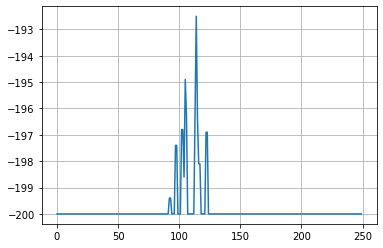

In [23]:
plt.plot(returns)
plt.grid()

In [24]:
policy = agent.policy

In [34]:
#policy = tf.saved_model.load("Good Policies/policy_60k")
#policy = tf.saved_model.load("100k_dqn")

In [35]:
episode_rewards = []
for _ in range(5):
    reward = 0.0
    time_step = eval_env.reset()
    while not time_step.is_last():
        eval_env_py.render()
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step)
        reward += time_step.reward
    episode_rewards.append(reward)

In [36]:
eval_env_py.close()

In [28]:
tf.reduce_mean(episode_rewards)

<tf.Tensor: shape=(), dtype=float32, numpy=-186.6>

In [29]:
tf.reduce_max(episode_rewards)

<tf.Tensor: shape=(), dtype=float32, numpy=-133.0>

In [30]:
tf.reduce_min(episode_rewards)

<tf.Tensor: shape=(), dtype=float32, numpy=-200.0>

In [31]:
tf.math.reduce_std(episode_rewards)

<tf.Tensor: shape=(), dtype=float32, numpy=26.8>